# BUGHOUSE TOURNAMENT CLASSIFICATION PREDICTION

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split


# Step 1: Load and Inspect the Data


In [2]:
# Load a dataset
df = pd.read_csv('bugzero_bughouse_data.csv')

# Display first few rows
df.head()

bugzero_win  complexity_pref1  complexity_pref2  opponent1_aggression  \
0            0              0.59              0.41                  0.38   
1            0              0.49              0.75                  0.34   
2            0              0.19              0.69                  0.33   
3            0              0.46              0.99                  0.44   
4            1              0.25              0.28                  0.50   

      opponent1_opening  opponent1_rating  opponent2_aggression  \
0        French Defense              2299                  0.15   
1             Ruy López              2172                  0.45   
2      Sicilian Defense              2330                  0.53   
3        Queen's Gambit              2505                  0.38   
4  Scandinavian Defense              2153                  0.50   

      opponent2_opening  opponent2_rating  opponent_id  
0         King's Gambit              2385            1  
1      Sicilian Defense              2582            2  
2        Queen's Gambit              1920            3  
3         King's Gambit              2313            4  
4  Scandinavian Defense              2070            5

# Step 2: Basic Summary Statistics

In [3]:
# Summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bugzero_win           500 non-null    int64  
 1   complexity_pref1      500 non-null    float64
 2   complexity_pref2      500 non-null    float64
 3   opponent1_aggression  500 non-null    float64
 4   opponent1_opening     500 non-null    object 
 5   opponent1_rating      500 non-null    int64  
 6   opponent2_aggression  500 non-null    float64
 7   opponent2_opening     500 non-null    object 
 8   opponent2_rating      500 non-null    int64  
 9   opponent_id           500 non-null    int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 39.2+ KB


In [4]:
# Descriptive statistics
df.describe()

bugzero_win  complexity_pref1  complexity_pref2  opponent1_aggression  \
count   500.000000        500.000000        500.000000            500.000000   
mean      0.456000          0.491440          0.497240              0.289140   
std       0.498559          0.288056          0.293401              0.156588   
min       0.000000          0.000000          0.000000              0.010000   
25%       0.000000          0.240000          0.247500              0.170000   
50%       0.000000          0.490000          0.480000              0.260000   
75%       1.000000          0.740000          0.770000              0.392500   
max       1.000000          1.000000          1.000000              0.780000   

       opponent1_rating  opponent2_aggression  opponent2_rating  opponent_id  
count        500.000000            500.000000          500.0000   500.000000  
mean        2201.216000              0.291200         2206.3660   250.500000  
std          195.725938              0.160417          195.5918   144.481833  
min         1552.000000              0.010000         1661.0000     1.000000  
25%         2060.000000              0.170000         2081.2500   125.750000  
50%         2203.000000              0.280000         2206.0000   250.500000  
75%         2327.500000              0.400000         2330.2500   375.250000  
max         2900.000000              0.810000         2726.0000   500.000000

In [5]:
# Data types and unique counts
for col in df.columns:
    print(f"{col}: {df[col].dtype}, Unique values: {df[col].nunique()}")


bugzero_win: int64, Unique values: 2
complexity_pref1: float64, Unique values: 101
complexity_pref2: float64, Unique values: 101
opponent1_aggression: float64, Unique values: 69
opponent1_opening: object, Unique values: 6
opponent1_rating: int64, Unique values: 354
opponent2_aggression: float64, Unique values: 71
opponent2_opening: object, Unique values: 6
opponent2_rating: int64, Unique values: 362
opponent_id: int64, Unique values: 500


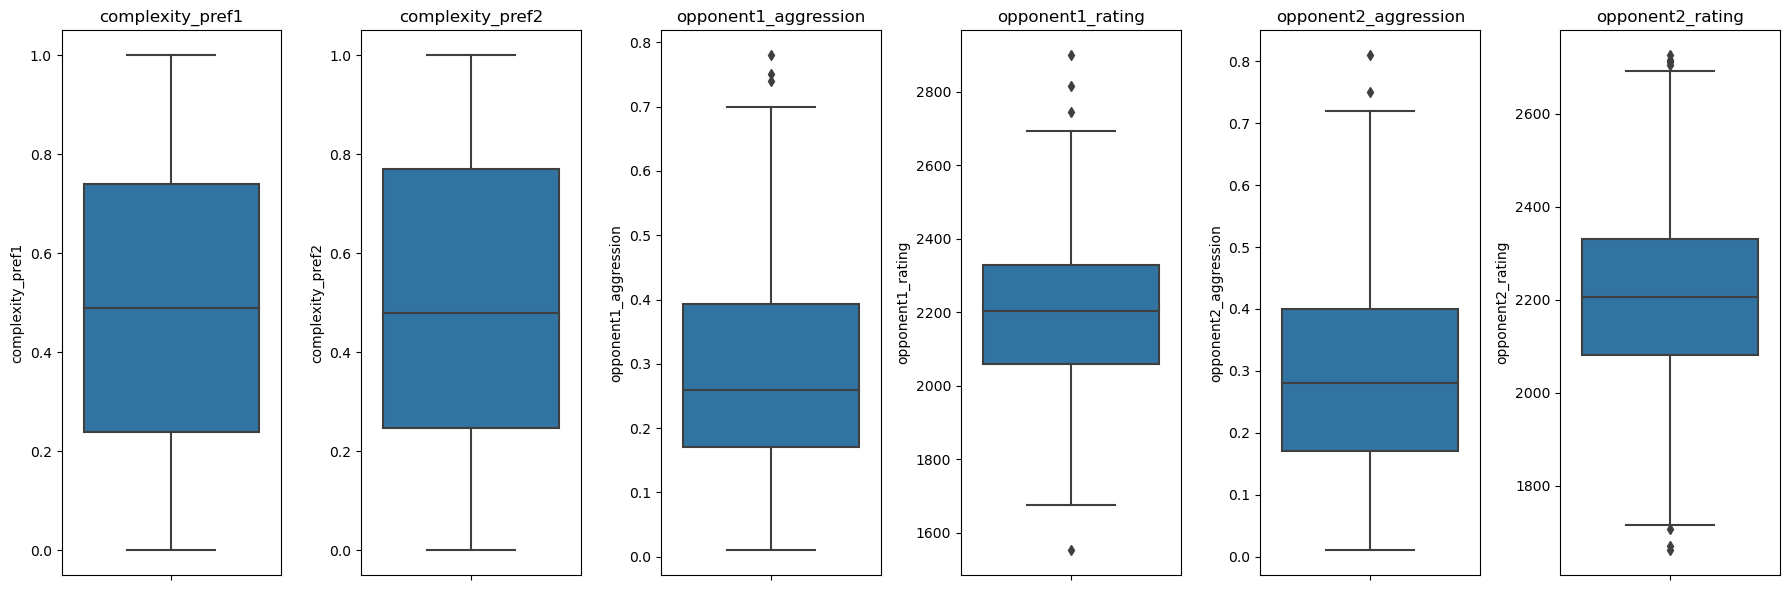

In [6]:
df_eda =df.copy()
# Select only numerical columns, excluding specific ones
excluded_cols = ['bugzero_win', 'opponent_id']
numerical_cols = [col for col in df_eda.select_dtypes(include=['int64', 'float64']).columns if col not in excluded_cols]

# Set up one row with len(numerical_cols) columns
num_cols = len(numerical_cols)
fig, axes = plt.subplots(1, num_cols, figsize=(3 * num_cols, 6))

# Ensure axes is iterable
if num_cols == 1:
    axes = [axes]

# Create vertical boxplots for each numerical feature
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


In [7]:
# Outlier Detection
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_eda[(df_eda[col] < Q1 - 1.5 * IQR) | (df_eda[col] > Q3 + 1.5 * IQR)]
    print(f'{col}: {len(outliers)} potential outliers')

complexity_pref1: 0 potential outliers
complexity_pref2: 0 potential outliers
opponent1_aggression: 3 potential outliers
opponent1_rating: 4 potential outliers
opponent2_aggression: 2 potential outliers
opponent2_rating: 7 potential outliers


# Step 3: Check for Missing Data

In [8]:
# Total missing values per column
print(df_eda.isnull().sum())


bugzero_win             0
complexity_pref1        0
complexity_pref2        0
opponent1_aggression    0
opponent1_opening       0
opponent1_rating        0
opponent2_aggression    0
opponent2_opening       0
opponent2_rating        0
opponent_id             0
dtype: int64


# Step 4: Target Balance


In [9]:
# Check for class imbalance
class_counts = df_eda['bugzero_win'].value_counts()
class_proportions = class_counts / len(df)

# Combine into a single DataFrame with two columns
class_summary = pd.DataFrame({'Count': class_counts,'Proportion': class_proportions})
print("Class Distribution and Proportion:")
print(class_summary)

Class Distribution and Proportion:
   Count  Proportion
0    272       0.544
1    228       0.456


54.4% vs. 45.6%, which is quite close.
This difference is mild — not enough to cause major issues for most models, including logistic regression.

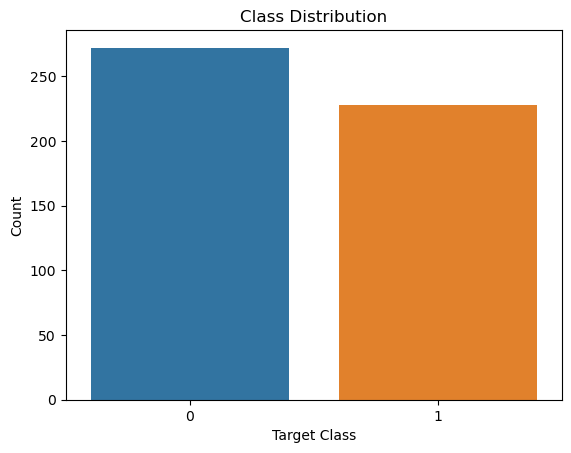

In [10]:
# Visualise class counts
sns.countplot(data=df_eda, x='bugzero_win')
plt.title('Class Distribution')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

# Step 5: Visualizations


a) Univariate Analysis

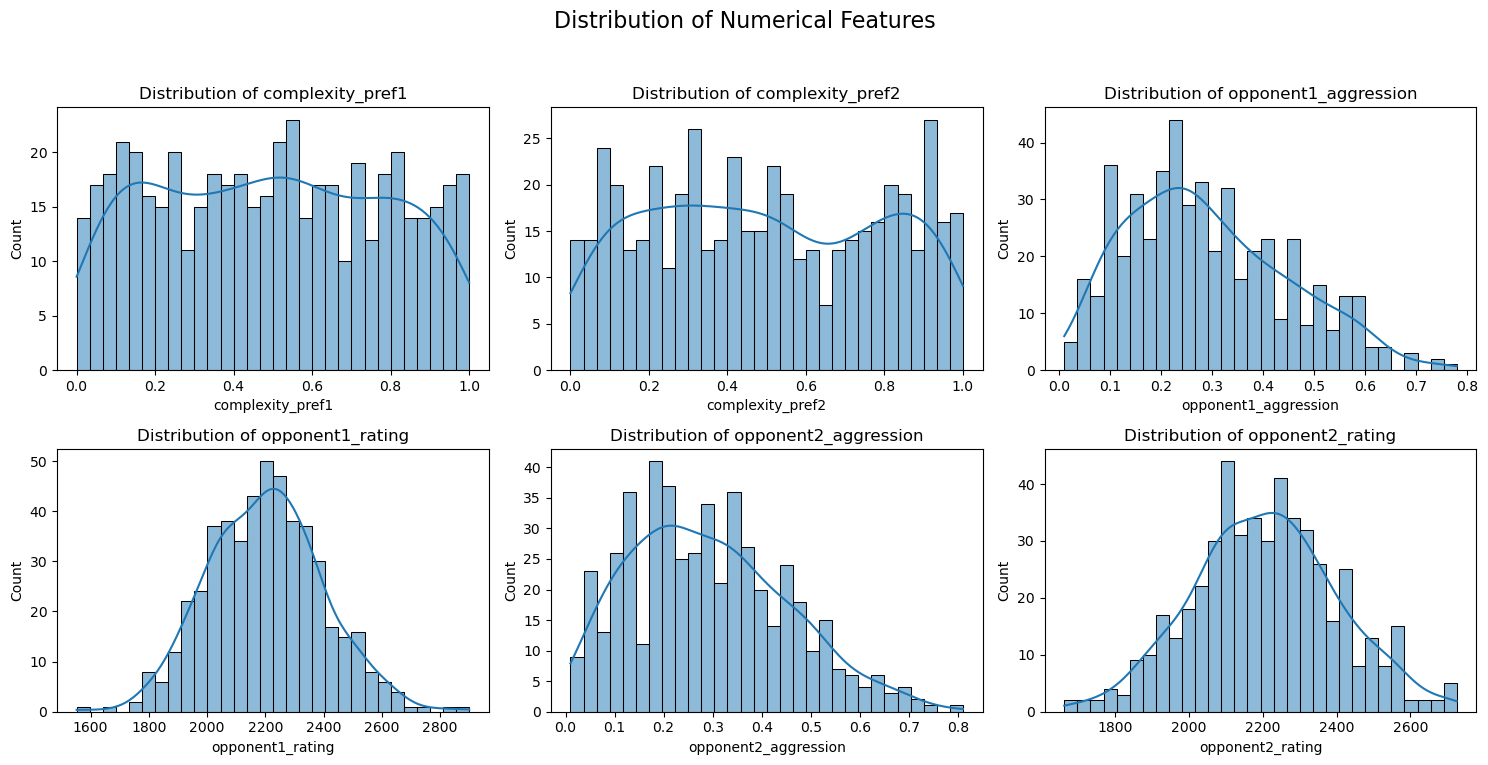

In [11]:
# Set up grid for histograms
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [12]:
# Value counts for opponent1_opening
print("Opponent 1 Opening Counts:")
print(df_eda['opponent1_opening'].value_counts())
print("\n")

# Value counts for opponent2_opening
print("Opponent 2 Opening Counts:")
print(df_eda['opponent2_opening'].value_counts())


Opponent 1 Opening Counts:
King's Gambit           93
Scandinavian Defense    87
Queen's Gambit          86
French Defense          81
Ruy López               77
Sicilian Defense        76
Name: opponent1_opening, dtype: int64


Opponent 2 Opening Counts:
King's Gambit           107
Sicilian Defense         83
Ruy López                82
French Defense           80
Queen's Gambit           74
Scandinavian Defense     74
Name: opponent2_opening, dtype: int64


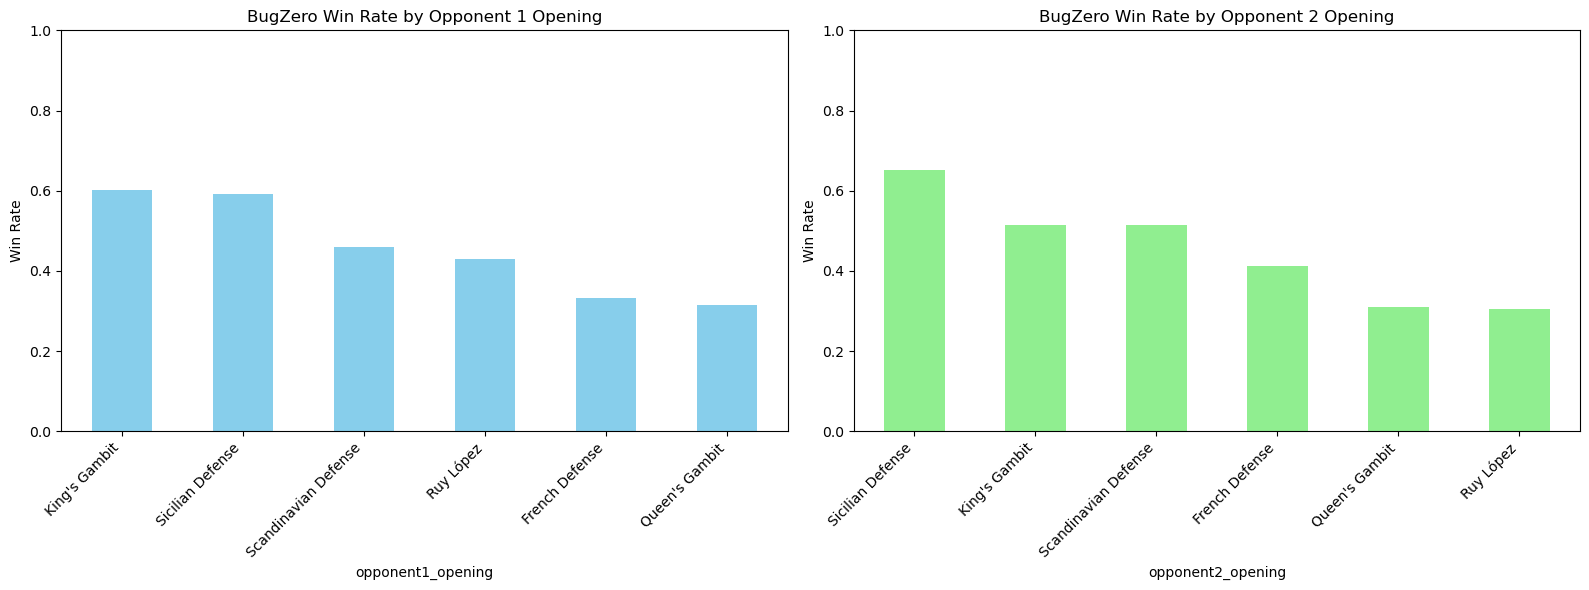

In [13]:
# Group by opening and calculate mean win rate for each
op1_winrate = df_eda.groupby('opponent1_opening')['bugzero_win'].mean().sort_values(ascending=False)
op2_winrate = df_eda.groupby('opponent2_opening')['bugzero_win'].mean().sort_values(ascending=False)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Opponent 1 Opening vs Win Rate
op1_winrate.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("BugZero Win Rate by Opponent 1 Opening")
axes[0].set_ylabel("Win Rate")
axes[0].set_ylim(0, 1)
axes[0].set_xticklabels(op1_winrate.index, rotation=45, ha='right')

# Opponent 2 Opening vs Win Rate
op2_winrate.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title("BugZero Win Rate by Opponent 2 Opening")
axes[1].set_ylabel("Win Rate")
axes[1].set_ylim(0, 1)
axes[1].set_xticklabels(op2_winrate.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


b) Bivariate Analysis

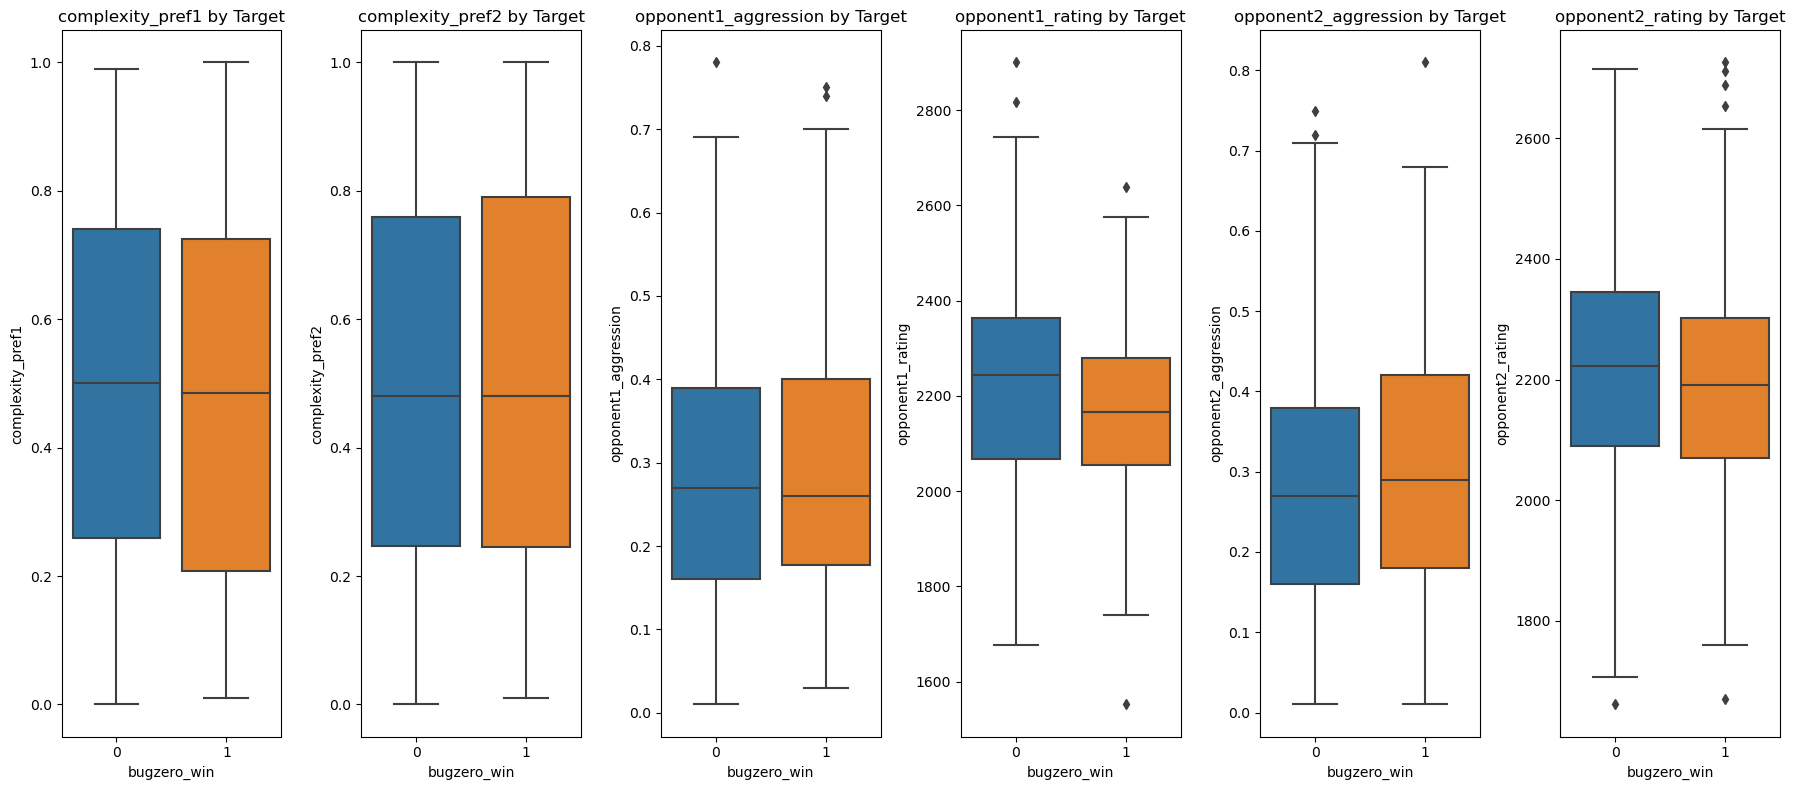

In [14]:
# Removing the target column if present in numerical_cols
numerical_cols = df_eda.select_dtypes(include=['int64', 'float64']).columns
numerical_features = [col for col in numerical_cols if col != 'bugzero_win' and col != 'opponent_id']
num_cols = len(numerical_features)

cols_per_row = num_cols  # All in one row
rows = 1

fig, axes = plt.subplots(rows, cols_per_row, figsize=(3 * num_cols, 8))

# Ensure axes is iterable
if num_cols == 1:
    axes = [axes]

for i, col in enumerate(numerical_features):
    sns.boxplot(x='bugzero_win', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Target')

plt.tight_layout()
plt.show()


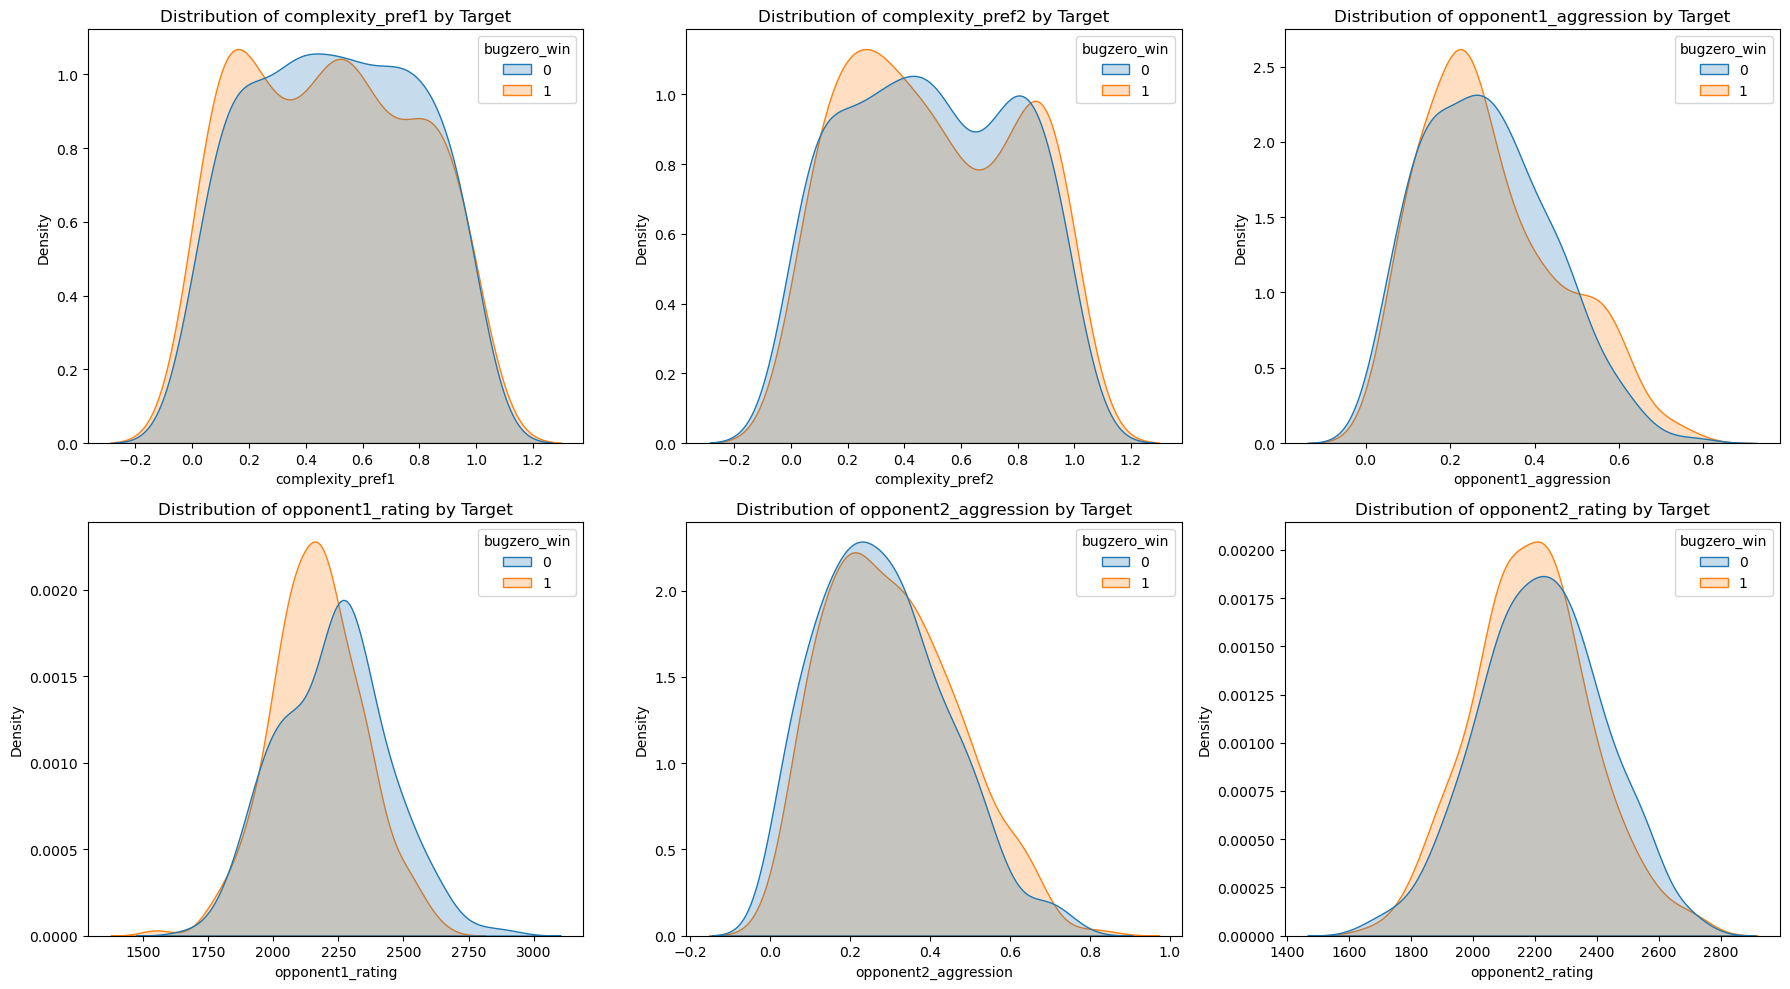

In [15]:
# KDE plot for numerical features by class
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 5 * rows))
axes = axes.flatten()

plot_idx = 0
for col in numerical_features:
    if df[col].nunique() > 1: 
        sns.kdeplot(data=df_eda, x=col, hue='bugzero_win', fill=True, ax=axes[plot_idx], common_norm=False)
        axes[plot_idx].set_title(f'Distribution of {col} by Target')
        plot_idx += 1

# Hide any unused axes
for j in range(plot_idx, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [16]:
# Group by both opponent openings and calculate mean win rate
combo_winrate = df_eda.groupby(['opponent1_opening', 'opponent2_opening'])['bugzero_win'].mean()

# Also count how many games each combo appears in
combo_counts = df_eda.groupby(['opponent1_opening', 'opponent2_opening']).size()

# Combine into a single DataFrame
combo_stats = pd.DataFrame({
    'win_rate': combo_winrate,
    'count': combo_counts
}).reset_index()

# Show top 10 combinations with highest win rates (with at least 5 games for reliability)
top_combos = combo_stats[combo_stats['count'] >= 5].sort_values(by='win_rate', ascending=False).head(10)

print(top_combos)


       opponent1_opening     opponent2_opening  win_rate  count
35      Sicilian Defense      Sicilian Defense  0.866667     15
28  Scandinavian Defense  Scandinavian Defense  0.769231     13
31      Sicilian Defense         King's Gambit  0.769231     13
7          King's Gambit         King's Gambit  0.736842     19
34      Sicilian Defense  Scandinavian Defense  0.727273     11
11         King's Gambit      Sicilian Defense  0.722222     18
23             Ruy López      Sicilian Defense  0.714286     14
29  Scandinavian Defense      Sicilian Defense  0.700000     10
5         French Defense      Sicilian Defense  0.615385     13
20             Ruy López        Queen's Gambit  0.600000     10


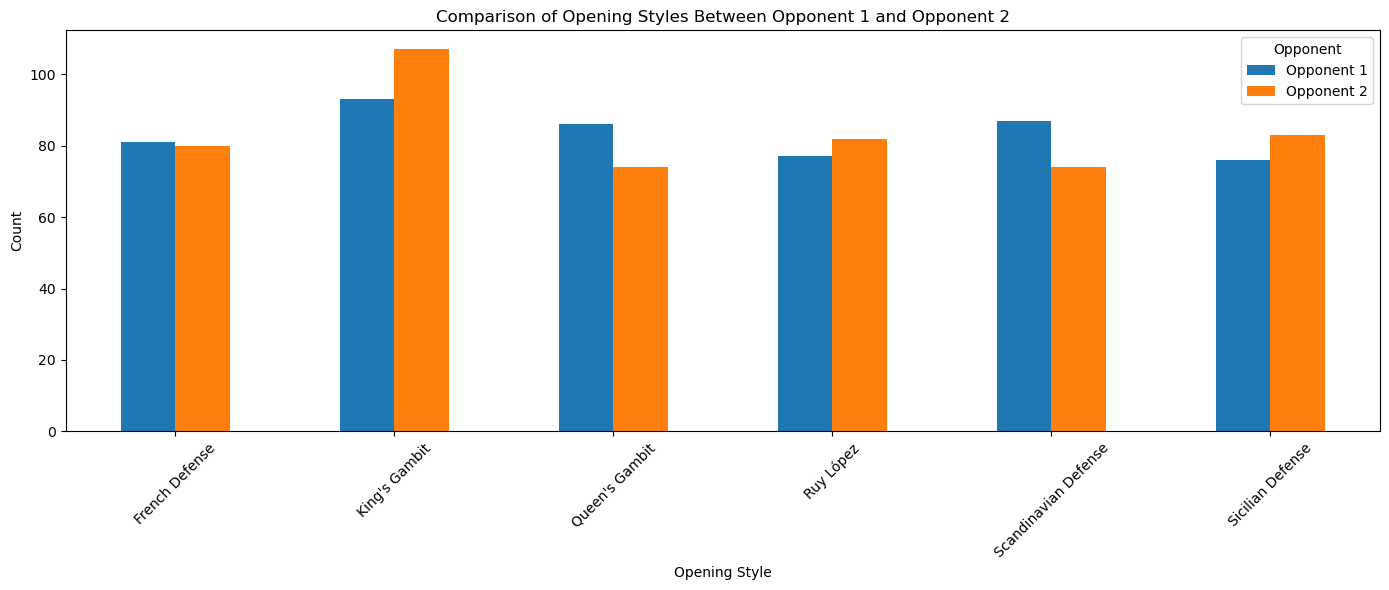

In [17]:
# Count openings for both opponents
op1_counts = df_eda['opponent1_opening'].value_counts()
op2_counts = df_eda['opponent2_opening'].value_counts()

# Combine into a DataFrame
opening_df = pd.DataFrame({
    'Opponent 1': op1_counts,
    'Opponent 2': op2_counts
}).fillna(0)  # fill NaN with 0 for openings not used by one of the opponents

# Plot
opening_df.plot(kind='bar', figsize=(14, 6))
plt.title("Comparison of Opening Styles Between Opponent 1 and Opponent 2")
plt.xlabel("Opening Style")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Opponent")
plt.tight_layout()
plt.show()


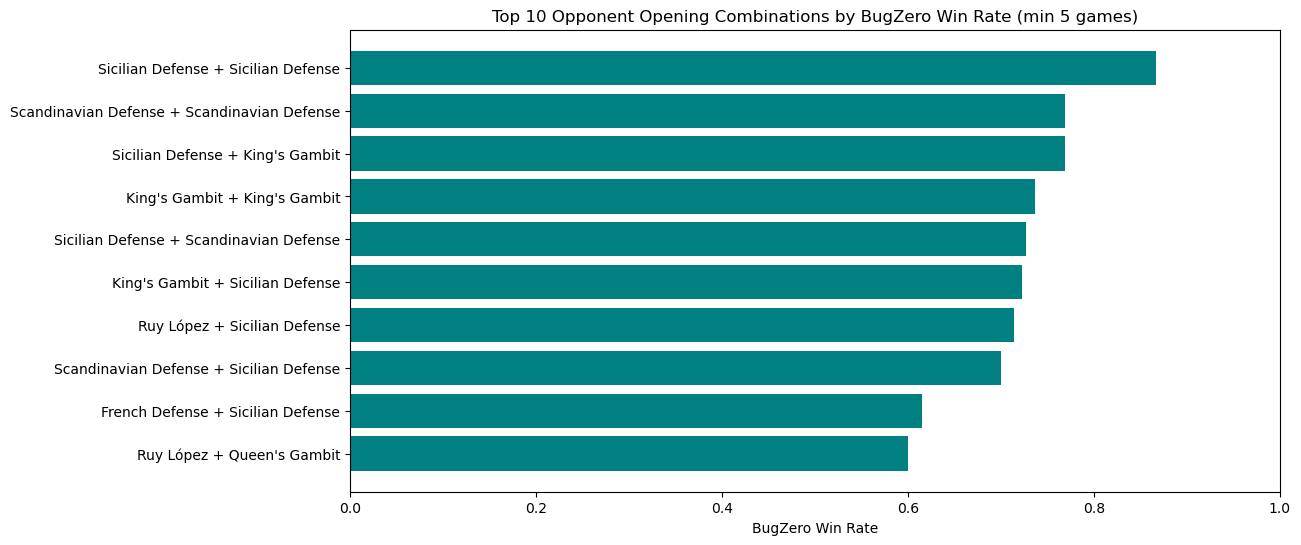

In [18]:
# Create a readable label combining both openings
top_combos['combo_label'] = top_combos['opponent1_opening'] + " + " + top_combos['opponent2_opening']

plt.figure(figsize=(12,6))
plt.barh(top_combos['combo_label'], top_combos['win_rate'], color='teal')
plt.xlabel('BugZero Win Rate')
plt.title('Top 10 Opponent Opening Combinations by BugZero Win Rate (min 5 games)')
plt.xlim(0,1)
plt.gca().invert_yaxis()  # highest win rate on top
plt.show()


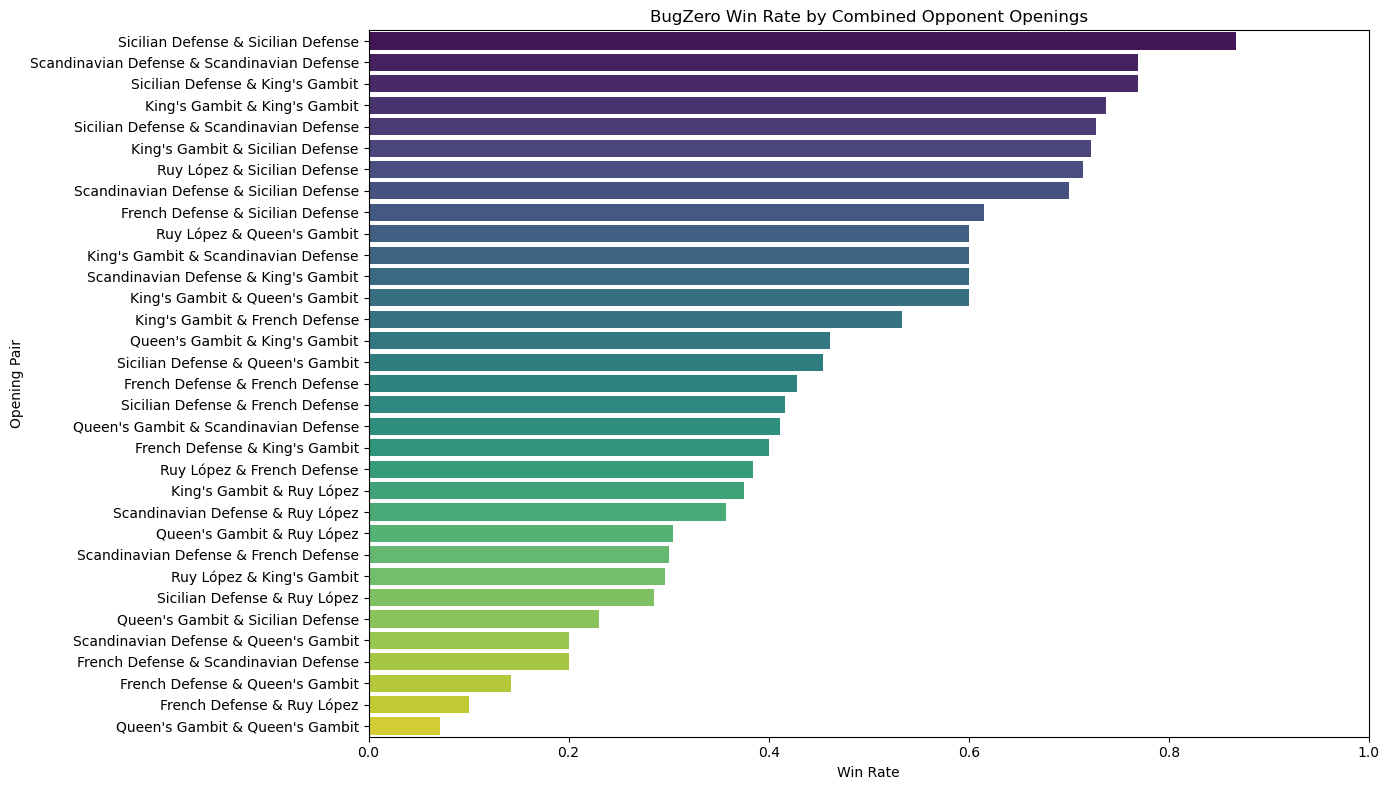

In [19]:
# Create a combined column of opening pairs
df_eda['opening_pair'] = df_eda['opponent1_opening'] + " & " + df_eda['opponent2_opening']

# Group by the opening pair and calculate win rate
pair_winrate = df_eda.groupby('opening_pair')['bugzero_win'].mean().sort_values(ascending=False)

# Filter to show only combinations with enough games (optional)
pair_counts = df_eda['opening_pair'].value_counts()
valid_pairs = pair_counts[pair_counts >= 10].index  # only pairs with at least 10 games
filtered_winrate = pair_winrate[pair_winrate.index.isin(valid_pairs)]

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x=filtered_winrate.values, y=filtered_winrate.index, palette="viridis")
plt.title("BugZero Win Rate by Combined Opponent Openings")
plt.xlabel("Win Rate")
plt.ylabel("Opening Pair")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()



*Source Bias*, such as "Sicilian Defense & Sicilian Defense" are impossible in Bughouse and will be addressed in section 2 Feature Engineering and Selection. 
So everytimes, we encounter for one game a double "Defense" openings for both opponents, we will drop that columns.

# Step 6: Correlation Analysis


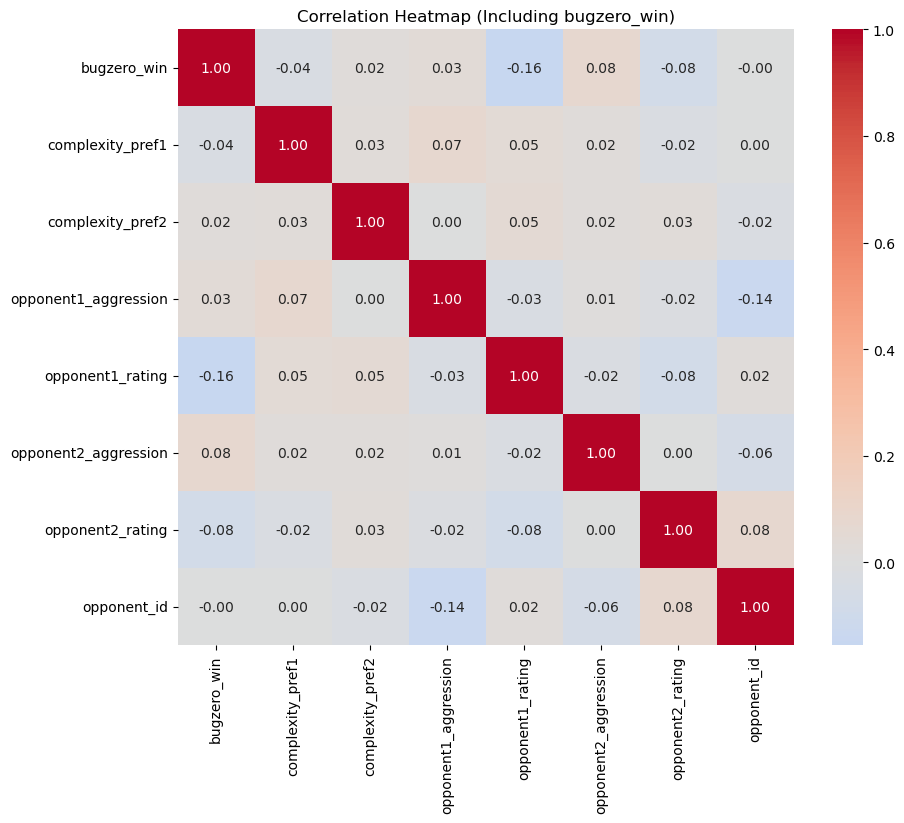

In [20]:
# Compute correlation matrix (numeric columns only)
corr_matrix = df_eda.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap (Including bugzero_win)")
plt.show()


To identify features most correlated with AI wins/losses.


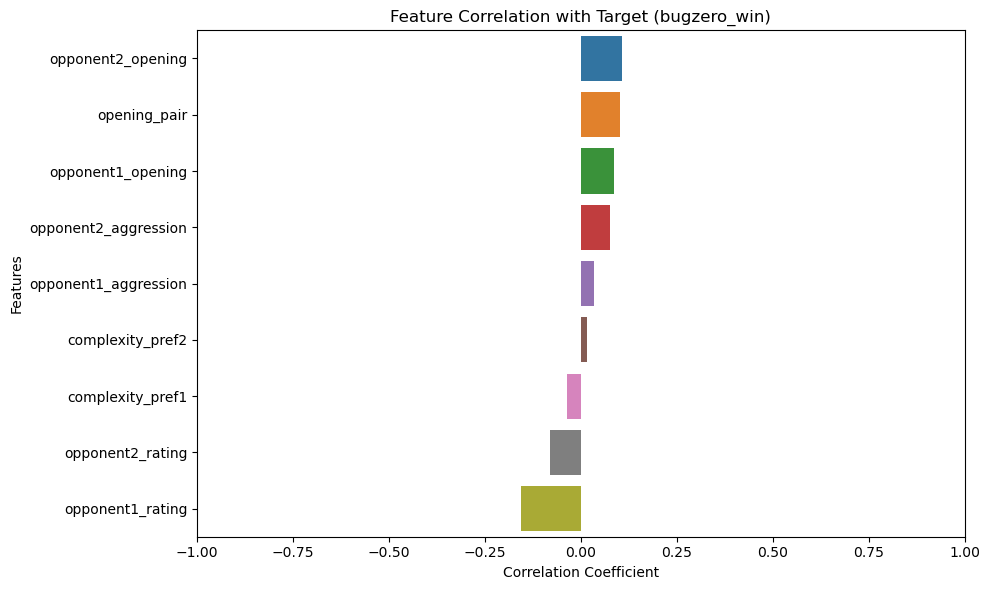

In [21]:
# Encode categorical features (excluding target)
#df_encoded = pd.get_dummies(df, columns=['opponent1_opening', 'opponent2_opening'], drop_first=True).copy()
#df_encoded['encoded_col'] = LabelEncoder().fit_transform(df_encoded['category_col'])

for col in df_eda.select_dtypes(include=['object', 'category']).columns:
    if col != 'bugzero_win':
        df_eda[col] = LabelEncoder().fit_transform(df_eda[col])
        #df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

        

# Compute correlation with target
target_corr = df_eda.corr()['bugzero_win'].sort_values(ascending=False)
#target_corr = df_encoded.corr()['bugzero_win'].sort_values(ascending=False)

# Drop 'bugzero_win' and 'opponent_id' from correlation list
target_corr_filtered = target_corr.drop(['bugzero_win'], errors='ignore')
if 'opponent_id' in target_corr_filtered.index:
    target_corr_filtered = target_corr_filtered.drop('opponent_id')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr_filtered.values, y=target_corr_filtered.index)

plt.title('Feature Correlation with Target (bugzero_win)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()


# Summary of EDA Insights


Are any features strongly correlated with winning?

Are any features skewed or requiring transformation?

Are there missing or anomalous values?

Is the dataset balanced between wins and losses?

Are categorical variables ready for modeling?

# 2. FEATURES Selection & Engineering

Discuss how you selected or engineered variables. Discuss why you did things. Discuss each interation


### 2.1. SOURCE BIAS

BIAS INTRODUCED DURING DATA COLLECTION

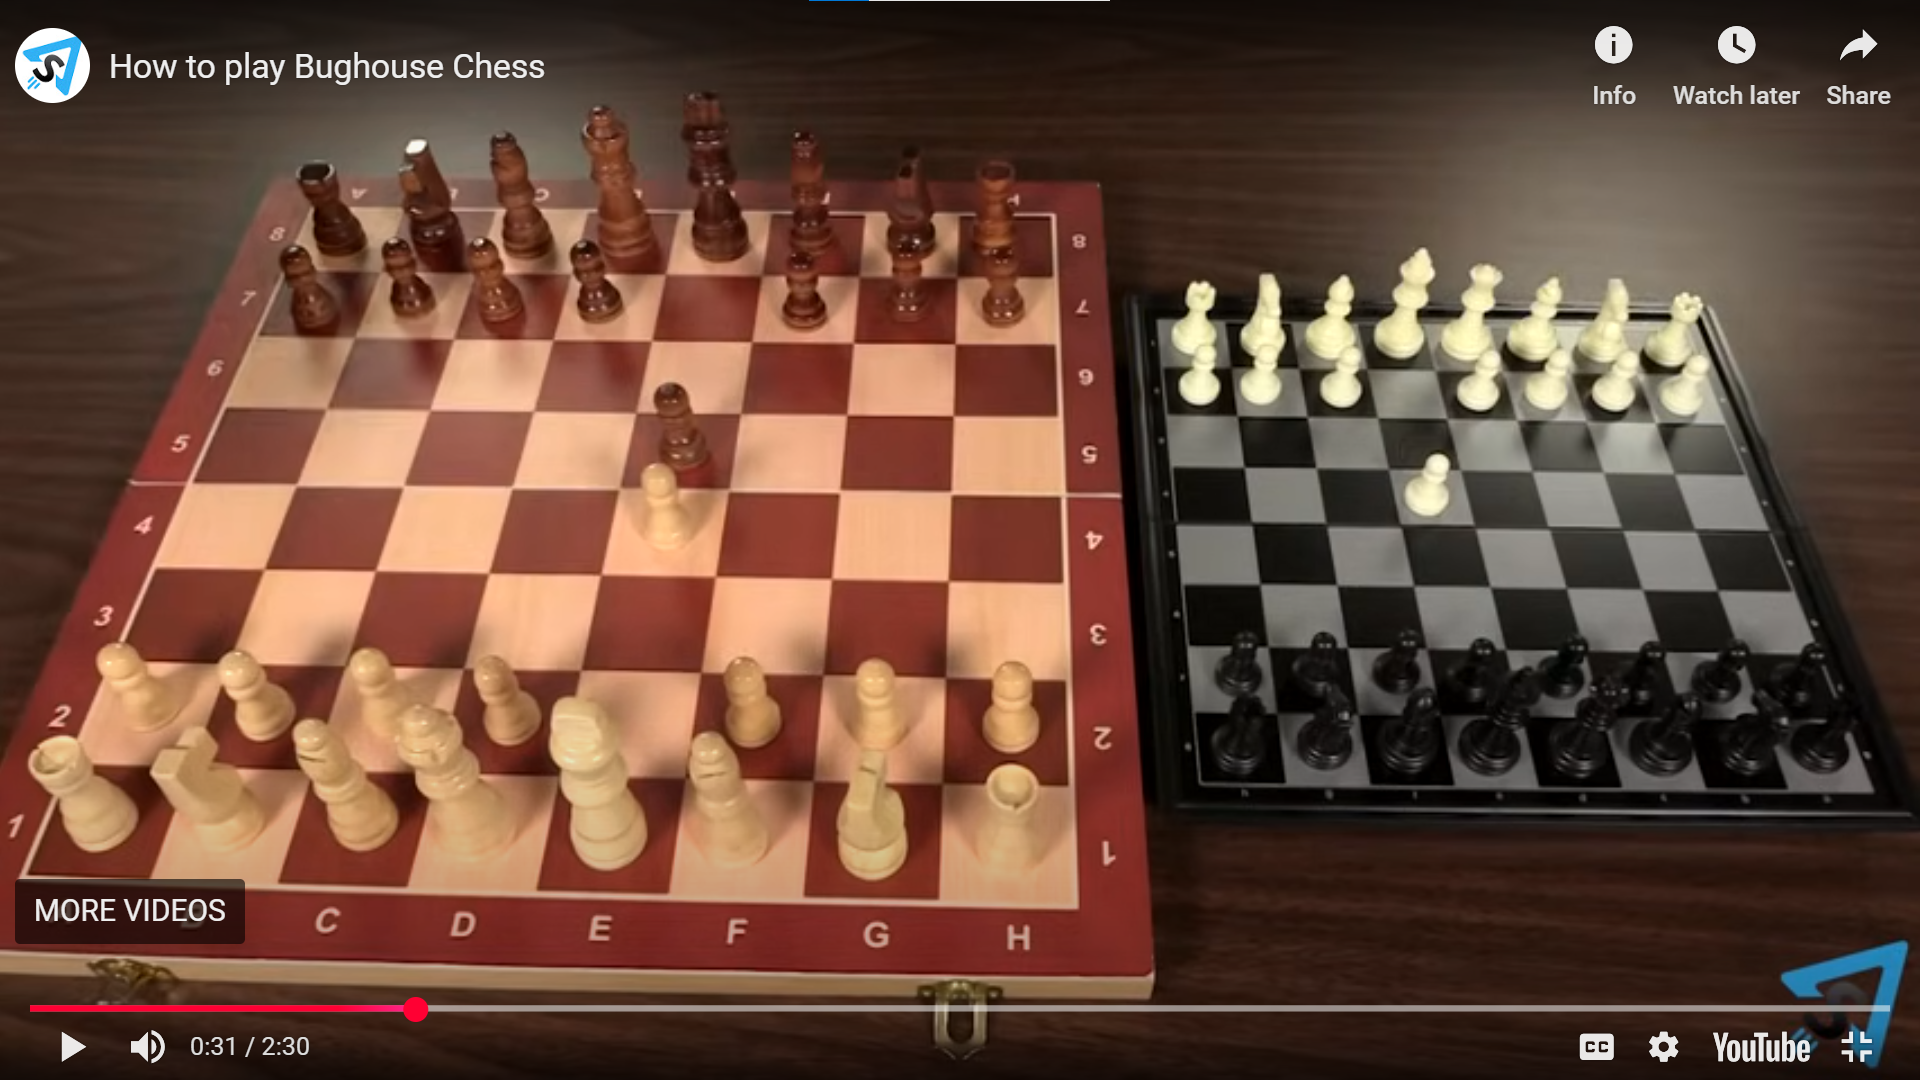

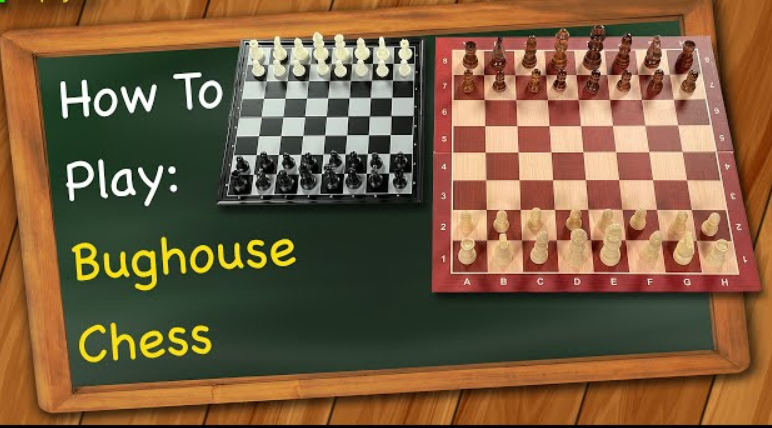

### Dropping unrealistic combinations in Team 2, 

Error occurred in the pairing of "Opponent1_opening" and "Opponent2_opening", based on the opening style feature.

In [22]:
# Count rows where both opponent1_opening and opponent2_opening contain the word "Gambit"
mask = (
    df['opponent1_opening'].str.contains("Defense", case=False, na=False) &
    df['opponent2_opening'].str.contains("Defense", case=False, na=False)
)

# Print the number of such rows
print("Number of rows with both openings containing 'Defense':", mask.sum())

# Drop those rows from the dataset
df_eng = df[~mask].reset_index(drop=True)


Number of rows with both openings containing 'Defense': 118


In [23]:
# Mask: rows where neither opening contains "Defense"
mask_no_gambit = ~df_eng['opponent1_opening'].str.contains("Defense", case=False, na=False) & \
                 ~df_eng['opponent2_opening'].str.contains("Defense", case=False, na=False)

# Count and print
print("Number of rows with no 'Defense' in either opening:", mask_no_gambit.sum())

# Drop those rows
df_eng2 = df_eng[~mask_no_gambit].reset_index(drop=True)
print("Remaining rows after both filters:", df_eng2.shape[0])

Number of rows with no 'Defense' in either opening: 137
Remaining rows after both filters: 245


# 2.1. Feature Engineering


a) One-Hot-Encoding

Convert opponent1_opening, opponent2_opening to numerical (e.g. using one-hot encoding) before fitting the model:


In [24]:
df_encoded = pd.get_dummies(df_eng2, columns=['opponent1_opening', 'opponent2_opening'], drop_first=True)

b) Combined Opponent Ratings


In [25]:
df_encoded['mean_opponent_rating'] = (df_encoded['opponent1_rating'] + df_encoded['opponent2_rating']) / 2
df_encoded['rating_diff'] = df_encoded['opponent1_rating'] - df_encoded['opponent2_rating']

Mean rating summarizes team strength.

Rating difference checks imbalance or if one opponent is carrying the team.


c) Features Scaling / Normalization

In [26]:
# Initialize scaler
scaler = MinMaxScaler()

# Reshape the column to 2D, fit-transform, and flatten back to Series
df_encoded['mean_opponent_rating'] = scaler.fit_transform(df_encoded[['mean_opponent_rating']])

In [28]:
df_encoded

bugzero_win  complexity_pref1  complexity_pref2  opponent1_aggression  \
0              0              0.59              0.41                  0.38   
1              0              0.49              0.75                  0.34   
2              0              0.19              0.69                  0.33   
3              0              0.34              0.33                  0.41   
4              1              0.95              0.44                  0.47   
..           ...               ...               ...                   ...   
240            1              0.46              0.94                  0.17   
241            1              0.63              0.93                  0.28   
242            0              0.28              0.15                  0.09   
243            0              0.56              0.51                  0.35   
244            0              0.09              0.46                  0.16   

     opponent1_rating  opponent2_aggression  opponent2_rating  opponent_id  \
0                2299                  0.15              2385            1   
1                2172                  0.45              2582            2   
2                2330                  0.53              1920            3   
3                2516                  0.22              2082            7   
4                2353                  0.11              2027            8   
..                ...                   ...               ...          ...   
240              2028                  0.19              2064          494   
241              2505                  0.22              2000          495   
242              2162                  0.30              2328          498   
243              2025                  0.24              2086          499   
244              1923                  0.04              2315          500   

     opponent1_opening_King's Gambit  opponent1_opening_Queen's Gambit  \
0                                  0                                 0   
1                                  0                                 0   
2                                  0                                 0   
3                                  1                                 0   
4                                  0                                 0   
..                               ...                               ...   
240                                0                                 0   
241                                0                                 1   
242                                0                                 0   
243                                0                                 1   
244                                0                                 0   

     opponent1_opening_Ruy López  opponent1_opening_Scandinavian Defense  \
0                              0                                       0   
1                              1                                       0   
2                              0                                       0   
3                              0                                       0   
4                              0                                       1   
..                           ...                                     ...   
240                            0                                       0   
241                            0                                       0   
242                            0                                       1   
243                            0                                       0   
244                            1                                       0   

     opponent1_opening_Sicilian Defense  opponent2_opening_King's Gambit  \
0                                     0                                1   
1                                     0                                0   
2                                     1                                0   
3                        

# 2.2. Feature Selection


We selected variables that represent opponent strength, style, and synergy, which are likely to influence whether your AI (BugZero) wins:


In [29]:
df_encoded.columns

Index(['bugzero_win', 'complexity_pref1', 'complexity_pref2',
       'opponent1_aggression', 'opponent1_rating', 'opponent2_aggression',
       'opponent2_rating', 'opponent_id', 'opponent1_opening_King's Gambit',
       'opponent1_opening_Queen's Gambit', 'opponent1_opening_Ruy López',
       'opponent1_opening_Scandinavian Defense',
       'opponent1_opening_Sicilian Defense', 'opponent2_opening_King's Gambit',
       'opponent2_opening_Queen's Gambit', 'opponent2_opening_Ruy López',
       'opponent2_opening_Scandinavian Defense',
       'opponent2_opening_Sicilian Defense', 'mean_opponent_rating',
       'rating_diff'],
      dtype='object')

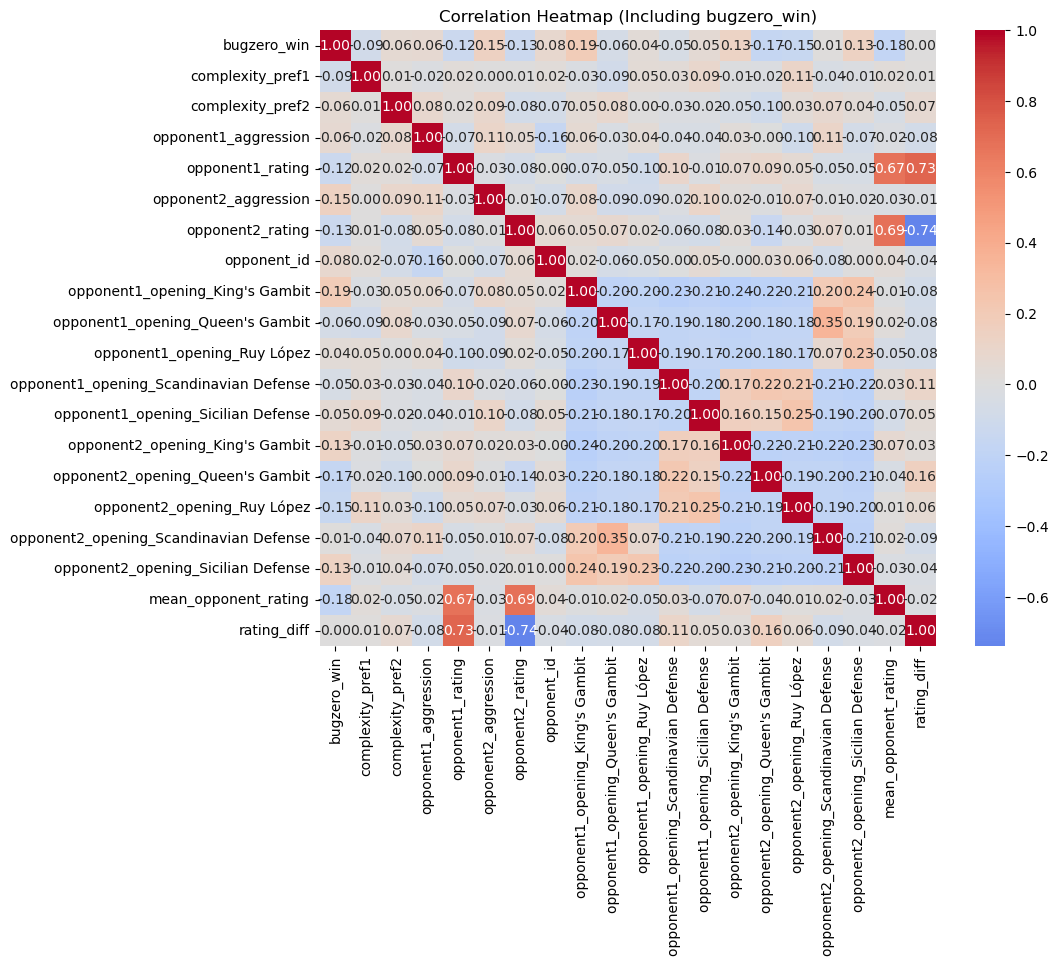

In [30]:
# Compute correlation matrix (numeric columns only)
corr_matrix = df_encoded.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap (Including bugzero_win)")
plt.show()

| Feature                                        | Type            | Why we kept it                                                                                                        |
| ---------------------------------------------- | --------------- | --------------------------------------------------------------------------------------------------------------------- |
| `opponent1_rating`, `opponent2_rating`         | Numerical       | Elo ratings represent skill level. Higher ratings should correlate with stronger opponents.                           |
| `opponent1_aggression`, `opponent2_aggression` | Numerical (0–1) | Measures tendency toward aggressive play. Might help detect risky opponents.                                          |
| `complexity_pref1`, `complexity_pref2`         | Numerical (0–1) | Indicates how comfortable opponents are with complex board states — relevant to decision making.                      |
| `similar_openings`                             | Binary          | Captures coordination between opponents. Synchronized play styles might give them an edge.                            |
| `interaction1`, `interaction2`                 | Engineered      | Combines aggression × opening, capturing interaction effects (e.g. aggressive Sicilian vs positional Queen’s Gambit). |
| `bugzero_win`                                  | Target (binary) | The target variable — whether BugZero won the game.                                                                   |


In [31]:
df_encoded.columns

Index(['bugzero_win', 'complexity_pref1', 'complexity_pref2',
       'opponent1_aggression', 'opponent1_rating', 'opponent2_aggression',
       'opponent2_rating', 'opponent_id', 'opponent1_opening_King's Gambit',
       'opponent1_opening_Queen's Gambit', 'opponent1_opening_Ruy López',
       'opponent1_opening_Scandinavian Defense',
       'opponent1_opening_Sicilian Defense', 'opponent2_opening_King's Gambit',
       'opponent2_opening_Queen's Gambit', 'opponent2_opening_Ruy López',
       'opponent2_opening_Scandinavian Defense',
       'opponent2_opening_Sicilian Defense', 'mean_opponent_rating',
       'rating_diff'],
      dtype='object')

# 2.3. What We Dropped and Why


In [32]:
df_encoded = df_encoded.drop(columns=['opponent_id','opponent1_rating', 'opponent2_rating', 'rating_diff'])


# 2.4. Multicollinearity Check


In [33]:
X = df_encoded.drop(columns=['bugzero_win'])

# VIF computation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIFs
print(vif_data.sort_values(by="VIF", ascending=False))


                                   feature       VIF
4          opponent1_opening_King's Gambit  6.357147
9          opponent2_opening_King's Gambit  6.169498
11             opponent2_opening_Ruy López  5.409812
5         opponent1_opening_Queen's Gambit  5.082186
10        opponent2_opening_Queen's Gambit  5.041899
6              opponent1_opening_Ruy López  4.593853
12  opponent2_opening_Scandinavian Defense  1.929628
13      opponent2_opening_Sicilian Defense  1.929140
7   opponent1_opening_Scandinavian Defense  1.666856
8       opponent1_opening_Sicilian Defense  1.633995
3                     opponent2_aggression  1.055996
2                     opponent1_aggression  1.051271
1                         complexity_pref2  1.036563
0                         complexity_pref1  1.028852
14                    mean_opponent_rating  1.022730


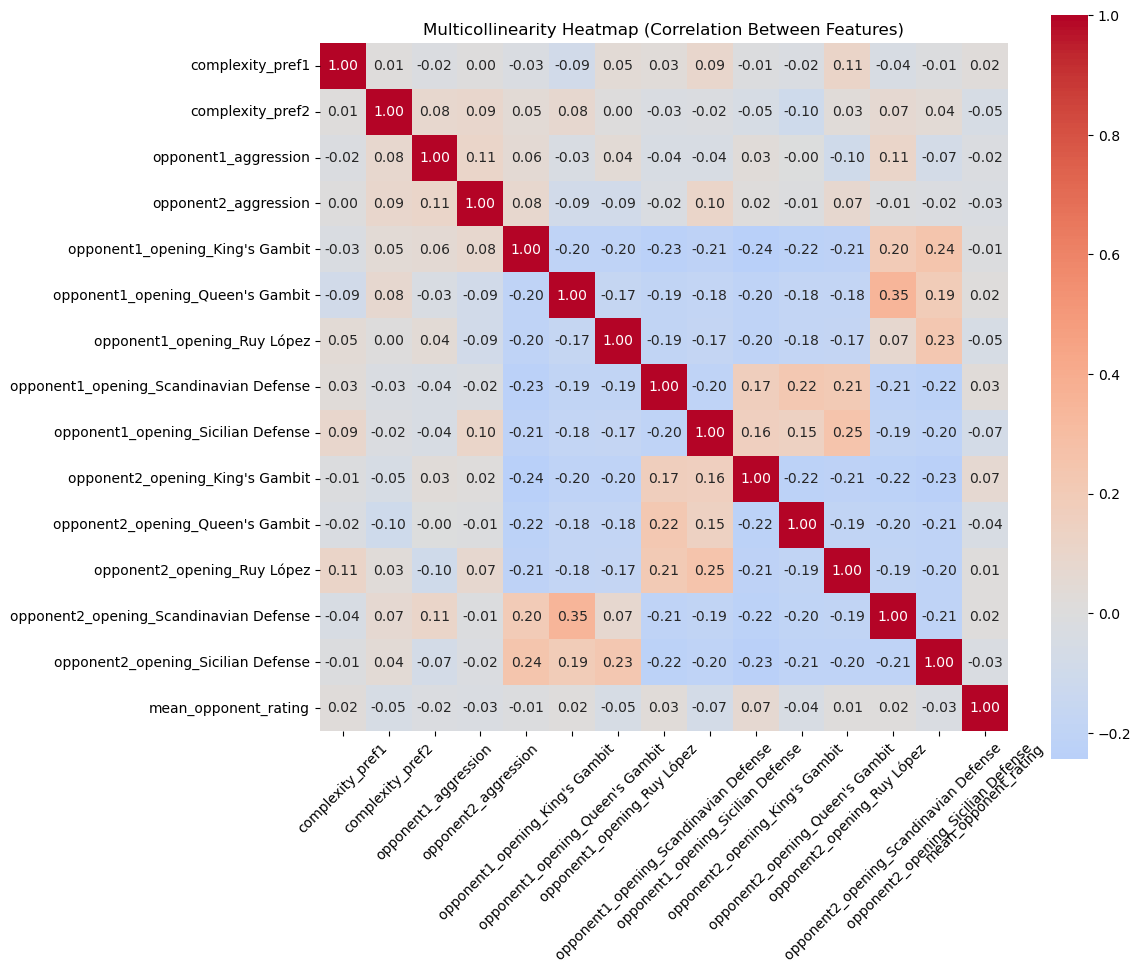

In [34]:
# Compute correlation matrix of features only (exclude target)
X = df_encoded.drop(columns=['bugzero_win'])
corr_matrix = X.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True)
plt.title("Multicollinearity Heatmap (Correlation Between Features)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Great — you're computing Variance Inflation Factor (VIF) to detect multicollinearity. To visualize multicollinearity, it's common to plot a correlation heatmap, since high correlations between features often indicate high VIFs.


In [35]:

# VIF computation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIFs
print(vif_data.sort_values(by="VIF", ascending=False))


                                   feature       VIF
4          opponent1_opening_King's Gambit  6.357147
9          opponent2_opening_King's Gambit  6.169498
11             opponent2_opening_Ruy López  5.409812
5         opponent1_opening_Queen's Gambit  5.082186
10        opponent2_opening_Queen's Gambit  5.041899
6              opponent1_opening_Ruy López  4.593853
12  opponent2_opening_Scandinavian Defense  1.929628
13      opponent2_opening_Sicilian Defense  1.929140
7   opponent1_opening_Scandinavian Defense  1.666856
8       opponent1_opening_Sicilian Defense  1.633995
3                     opponent2_aggression  1.055996
2                     opponent1_aggression  1.051271
1                         complexity_pref2  1.036563
0                         complexity_pref1  1.028852
14                    mean_opponent_rating  1.022730


ACTION :
Dropped features with VIF > 10, which indicates strong collinearity (e.g. between opponent1_rating and mean_opponent_rating).



# 2.6.Feature Engineering / Preprocessing 

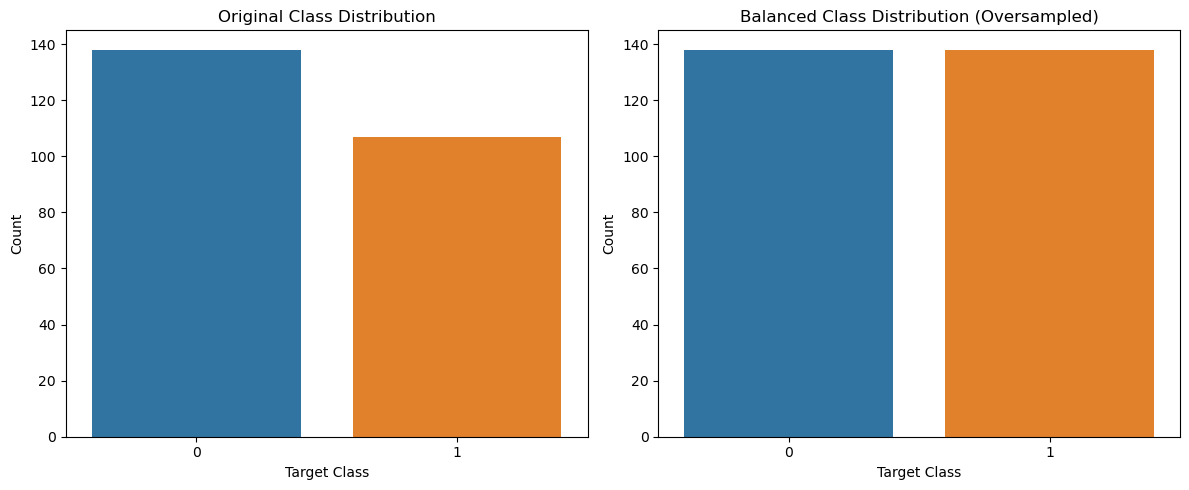

In [36]:
# Separate majority and minority classes
df_majority = df_encoded[df_encoded['bugzero_win'] == df_encoded['bugzero_win'].mode()[0]]
df_minority = df_encoded[df_encoded['bugzero_win'] != df_encoded['bugzero_win'].mode()[0]]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Plot original and balanced distributions side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original data
sns.countplot(data=df_encoded, x='bugzero_win', ax=axes[0])
axes[0].set_title('Original Class Distribution')
axes[0].set_xlabel('Target Class')
axes[0].set_ylabel('Count')

# Balanced data
sns.countplot(data=df_balanced, x='bugzero_win', ax=axes[1])
axes[1].set_title('Balanced Class Distribution (Oversampled)')
axes[1].set_xlabel('Target Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [37]:
# Check for class imbalance
class_counts = df_encoded['bugzero_win'].value_counts()
class_proportions = class_counts / len(df_encoded)

# Combine into a single DataFrame with two columns
class_summary = pd.DataFrame({'Count': class_counts,'Proportion': class_proportions})
print("Class Distribution and Proportion:")
print(class_summary)

Class Distribution and Proportion:
   Count  Proportion
0    138    0.563265
1    107    0.436735


# 3. MODELLING

Fit the model using a training set. Use a validation set to tune the hyperparameters/features of your model. Give the final accuracy of your tuned model on the test set

### 3.1.BASELINE MODEL using imbalanced class

Step 1: Prepare Data

In [39]:
# Define features and target
X = df_encoded.drop(columns=['bugzero_win'])
y = df_encoded['bugzero_win']

# Split into training (60%), validation (20%), and test (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)


Step 2: Train Logistic Regression Model (Base Model)

Validation Accuracy (Base Model): 0.5918
Accuracy:           0.5918
Precision:          0.5714
Recall:             0.3636
F1 Score:           0.4444
Balanced Accuracy:  0.5707
AUC:                0.5522


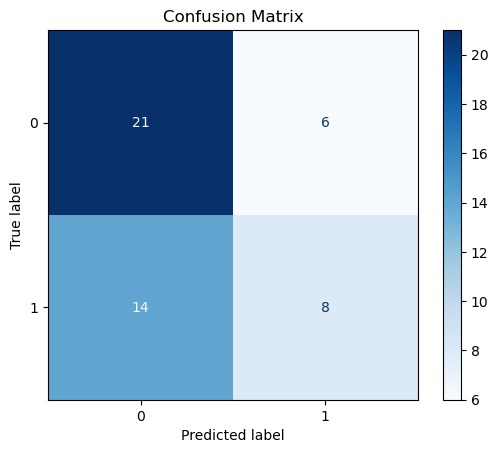

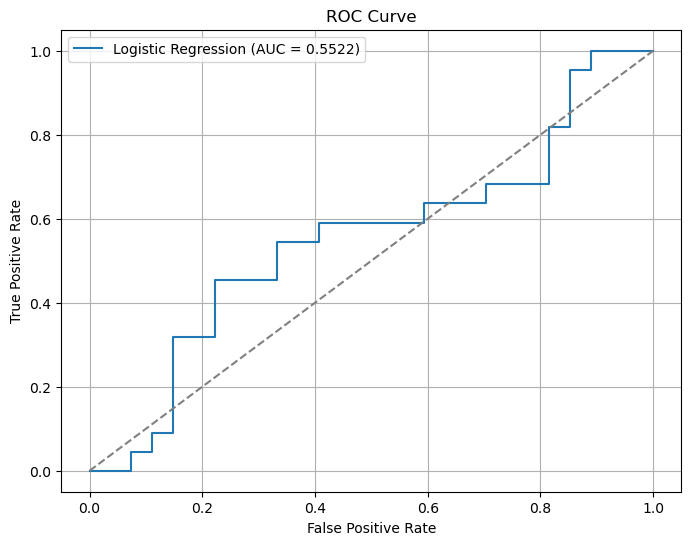

In [40]:
# Base model
base_model = LogisticRegression(max_iter=1000, solver='liblinear')
base_model.fit(X_train, y_train)

# Validation accuracy
y_val_pred = base_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Base Model): {val_acc:.4f}")


# Predictions and probabilities
y_val_pred = base_model.predict(X_val)
y_val_proba = base_model.predict_proba(X_val)[:, 1]

# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_proba)

# Print metrics
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision:          {precision:.4f}")
print(f"Recall:             {recall:.4f}")
print(f"F1 Score:           {f1:.4f}")
print(f"Balanced Accuracy:  {balanced_acc:.4f}")
print(f"AUC:                {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


Step 3: Tune Hyperparameters and Features


a. Hyperparameter Tuning


We'll use GridSearchCV to tune regularization strength C and penalty:

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports L1
}

grid_model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_model.fit(X_train, y_train)

print(f"Best Parameters: {grid_model.best_params_}")
best_model = grid_model.best_estimator_
# Step 4: Final Evaluation on Test Set
# Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_acc:.4f}")


Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Final Test Accuracy: 0.6327


# 3.2. Class imbalanced addressed now


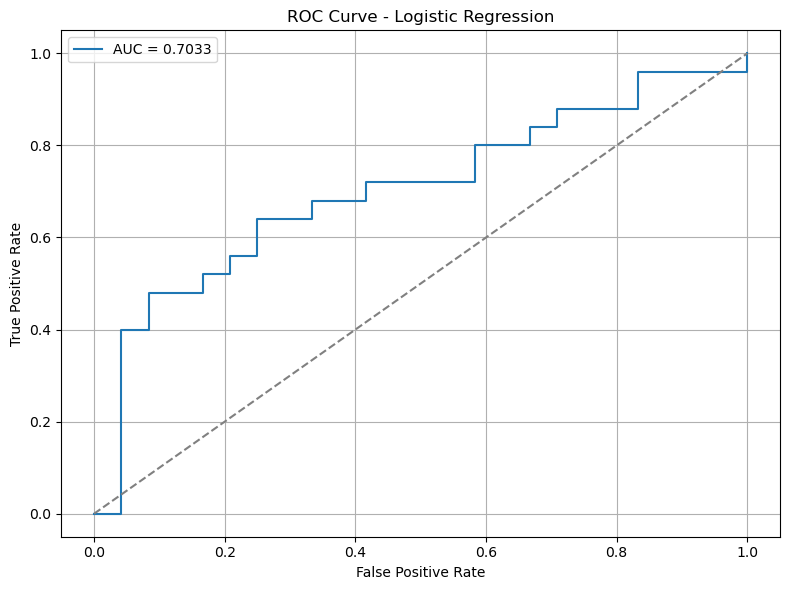

🔍 Evaluation Metrics:
Accuracy : 0.6939
Precision: 0.8571
Recall   : 0.4800
F1 Score : 0.6154
AUC      : 0.7033

📊 Classification Report:
              precision    recall  f1-score   support

        Lose       0.63      0.92      0.75        24
         Win       0.86      0.48      0.62        25

    accuracy                           0.69        49
   macro avg       0.74      0.70      0.68        49
weighted avg       0.75      0.69      0.68        49



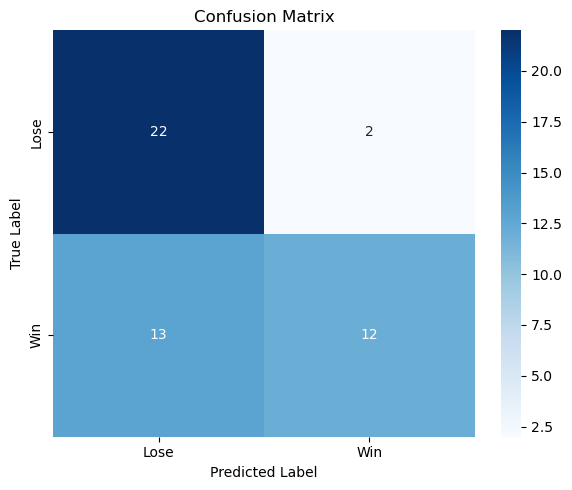

In [42]:
# Predict probabilities for ROC
y_test_proba = base_model.predict_proba(X_test)[:, 1]
y_test_pred = base_model.predict(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print metrics
print("🔍 Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Lose', 'Win']))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lose', 'Win'], yticklabels=['Lose', 'Win'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# BEST PERFORMANCE

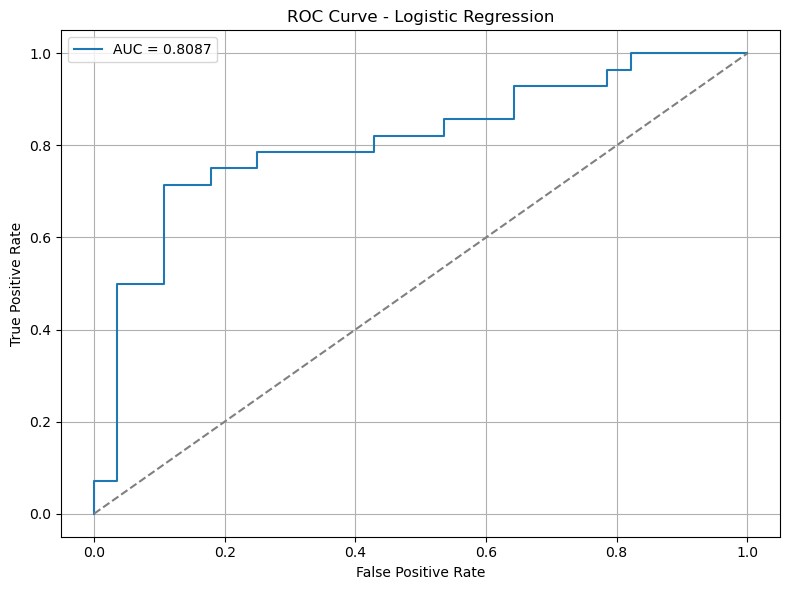

🔍 Evaluation Metrics:
Accuracy : 0.7679
Precision: 0.8000
Recall   : 0.7143
F1 Score : 0.7547
AUC      : 0.8087

📊 Classification Report:
              precision    recall  f1-score   support

        Lose       0.74      0.82      0.78        28
         Win       0.80      0.71      0.75        28

    accuracy                           0.77        56
   macro avg       0.77      0.77      0.77        56
weighted avg       0.77      0.77      0.77        56



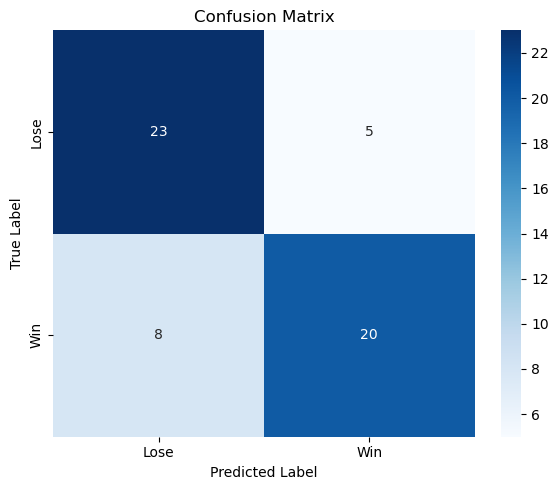

In [43]:
# Define features and target
X = df_balanced.drop(columns=['bugzero_win'])
y = df_balanced['bugzero_win']

# Split into training (60%), validation (20%), and test (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)


# Predict probabilities for ROC
y_test_proba = base_model.predict_proba(X_test)[:, 1]
y_test_pred = base_model.predict(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print metrics
print("🔍 Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Lose', 'Win']))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lose', 'Win'], yticklabels=['Lose', 'Win'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
